# Image Captioning with CNN + Default Transformer

This notebook implements an image captioning system using a CNN-Transformer architecture. The system consists of two main components:
1. A CNN (ResNet-50) encoder that extracts features from images
2. A standard Transformer decoder that generates captions based on these features

## Environment Setup and Dependencies

First, we'll import all necessary libraries:
- PyTorch for deep learning
- torchvision for image processing and pretrained models
- transformers for tokenization
- pycocotools for working with the COCO dataset
- Various utility libraries for data handling and visualization

We also set up reproducibility by fixing random seeds and configure the device (CPU/GPU) for training.

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pycocotools.coco import COCO
import time
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.cider.cider import Cider
from transformers import AutoTokenizer
from torchinfo import summary

os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.backends.cuda.matmul.allow_tf32 = True

# Set random seeds for reproducibility
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='cuda')

## Dataset Configuration and Loading

Here we define the CocoDataset class and set up data loading pipeline:

1. **CocoDataset Class**: 
   - Custom PyTorch Dataset class for handling COCO data
   - Loads image-caption pairs from the COCO dataset
   - Applies necessary transformations to images

2. **Data Transformations**:
   - Training: Includes data augmentation (random cropping, random erasing)
   - Validation: Basic resizing and normalization only

3. **DataLoader Configuration**:
   - Batch processing setup
   - Shuffling for training data
   - Proper normalization using ImageNet statistics

In [ ]:
class CocoDataset(Dataset):
    def __init__(self, root_dir, ann_file, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images
            ann_file (string): Path to annotation file
            transform: Transform pipeline for images
        """
        self.root_dir = root_dir
        self.transform = transform
        self.coco = COCO(ann_file)
        self.ids = list(self.coco.anns.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        """Returns one data pair (image and caption)."""
        ann_id = self.ids[idx]
        caption = self.coco.anns[ann_id]['caption']
        img_id = self.coco.anns[ann_id]['image_id']
        path = self.coco.loadImgs(img_id)[0]['file_name']

        # Load and transform image
        image = Image.open(os.path.join(self.root_dir, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        return image, caption, img_id

# Define the transforms with augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Larger size for random cropping
    transforms.RandomCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5)
])

# Simpler transform pipeline for validation/testing
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # No random cropping during validation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

## Data Exploration and Visualization

Before training, we explore and visualize our dataset to understand:
- Image preprocessing results
- Caption format and length
- Batch structure and organization

We also test our data loading pipeline by:
1. Extracting a batch of data
2. Displaying sample images with their captions
3. Verifying the tensor shapes and structures

In [ ]:
# Define base paths
BASE_PATH = 'data'
IMG_DIR = os.path.join(BASE_PATH, 'images')
ANN_DIR = os.path.join(BASE_PATH, 'annotations/trainval2017')

In [ ]:
# Create datasets
train_dataset = CocoDataset(
    root_dir=os.path.join(IMG_DIR, 'train2017'),
    ann_file=os.path.join(ANN_DIR, 'captions_train2017.json'),
    transform=train_transform,
) 

val_dataset = CocoDataset(
    root_dir=os.path.join(IMG_DIR, 'val2017'),
    ann_file=os.path.join(ANN_DIR, 'captions_val2017.json'),
    transform=val_transform,
)


# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True, num_workers=0)
print(len(train_loader), len(val_loader))
print(len(train_loader.dataset), len(val_loader.dataset))

loading annotations into memory...
Done (t=0.97s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
18493 782
591753 25014


In [ ]:
# Create a dataloader itterable object
dataiter = next(iter(val_loader))
# Sample from the itterable object
test_images, test_captions, test_img_ids = dataiter

A smiling man is wearing a hot pink tie.
('A smiling man is wearing a hot pink tie.', 'a zebra grazes on some green grass next to some trees ', 'A man with an umbrella is smiling on a cloudy day.', 'A man preparing food on a large old oven.', 'A boy is riding a skateboard past many food carts.', 'Two women ride horses in the water at the beach.', 'A cat sits on the edge of a toilet.', 'Two giraffe standing on a field together grazing on green grass.', 'A river is seen from afar and the river is next to a city that features old buildings.', 'there is a yellow and red train at a train stop', 'A grand piano in a formal residential living room', 'A person that is snowboarding in some snow.', 'The clock tower is on the first floor of the tall building. ', 'a man is holding some stuff standing by the curb', 'A boy is hitting a tennis ball on a tennis court. ', 'There is a small bathroom with a white vanity.', 'Two rusty parking meters are displayed with graffiti in the background.', 'A tenni

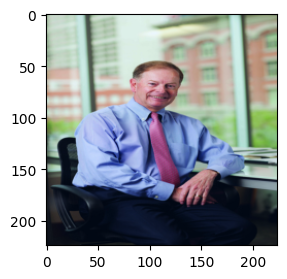

In [ ]:
# Lets visualise an entire batch of images
plt.figure(figsize = (3,3))
out = torchvision.utils.make_grid(test_images[0:1], 1, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

caption = test_captions[0]
print(caption)
print(test_captions)

Displaying 3 random samples from the dataset...

Sample 1:
--------------------------------------------------------------------------------


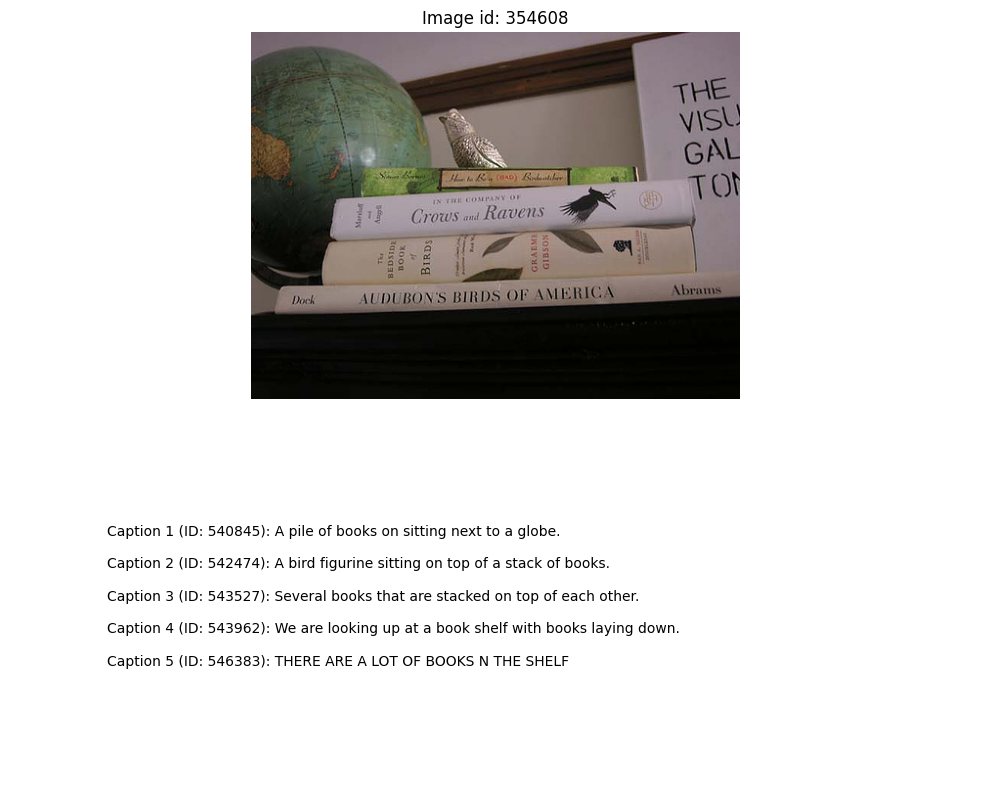


Sample 2:
--------------------------------------------------------------------------------


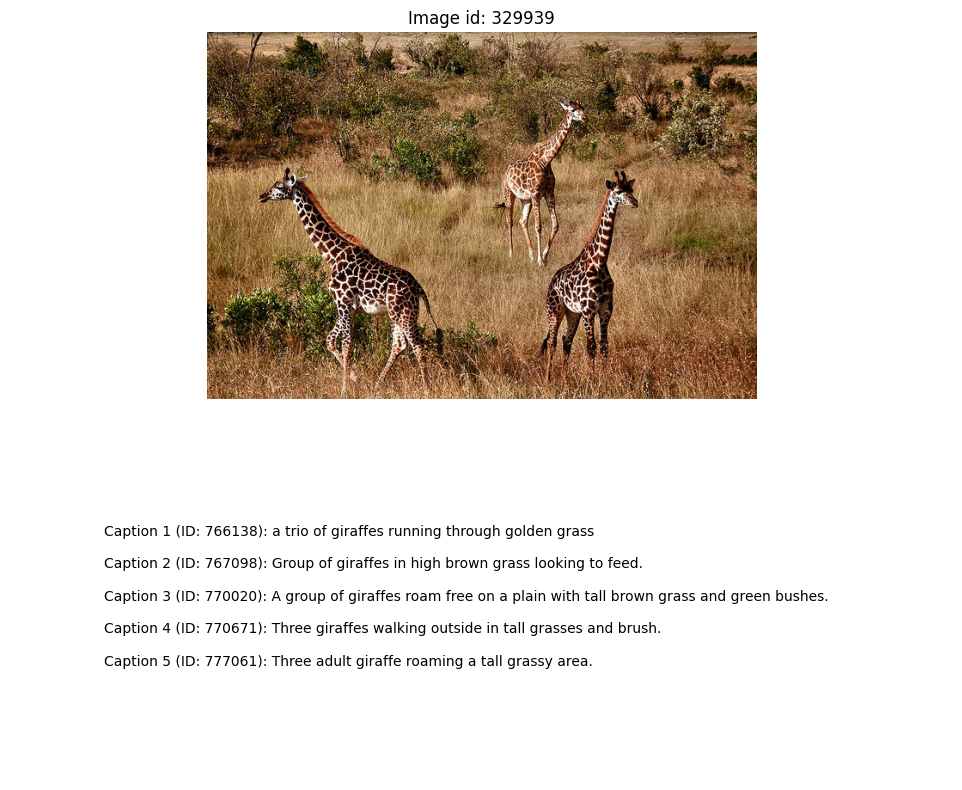


Sample 3:
--------------------------------------------------------------------------------


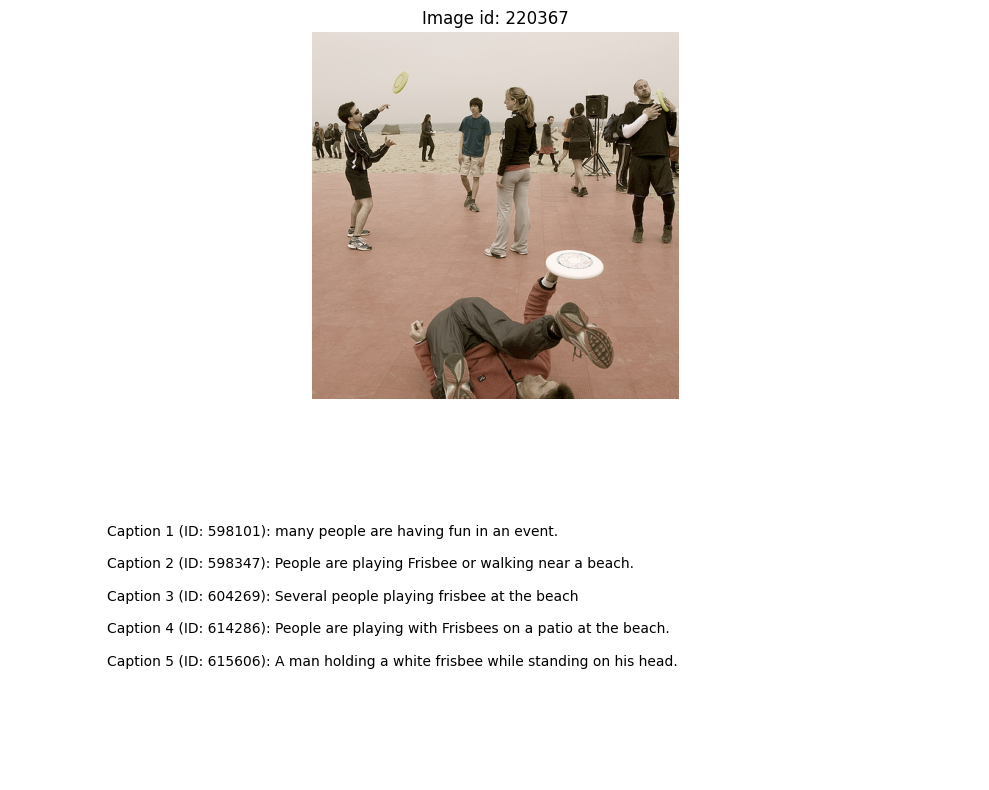

In [ ]:
def display_dataset_samples(dataset, num_samples=3):
    """
    Display multiple random samples from the dataset with their captions.

    Args:
        dataset: CocoDataset instance
        num_samples: Number of samples to display
    """
    coco_caps = dataset.coco
    root_dir = dataset.root_dir

    print(f"Displaying {num_samples} random samples from the dataset...")

    for i in range(num_samples):
        print(f"\nSample {i+1}:")
        print("-" * 80)

        # Get a random image ID
        img_ids = coco_caps.getImgIds()
        img_id = random.choice(img_ids)

        # Load image info
        img_info = coco_caps.loadImgs([img_id])[0]

        # Load image using PIL
        img_path = os.path.join(root_dir, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')

        # Get and display captions
        ann_ids = coco_caps.getAnnIds(imgIds=img_id)
        anns = coco_caps.loadAnns(ann_ids)

        # Create text display for captions
        caption_text = '\n\n'.join([f"Caption {i+1} (ID: {ann['id']}): {ann['caption']}"
                                   for i, ann in enumerate(anns)])

        # Display image and captions
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        ax1.imshow(image)
        ax1.axis('off')
        ax1.set_title('Image id: ' + str(img_id))
        ax2.text(0.1, 0.5, caption_text,
                 wrap=True,
                 verticalalignment='center',
                 fontsize=10)
        ax2.axis('off')
        plt.tight_layout()
        plt.show()

# Display some samples from the training dataset
display_dataset_samples(train_dataset, num_samples=3)

## Tokenization Configuration

We use the DistilBERT tokenizer for processing text:
1. Initialize the tokenizer
2. Test tokenization on sample captions
3. Verify token sequences and vocabulary size
4. Display tokenized outputs for understanding the text preprocessing

This helps us understand how captions are converted into a format suitable for the Transformer decoder.

In [ ]:
# Initialize tokenizer once
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
print(tokenizer.vocab_size)

# Let's test with one caption
sample_caption = test_captions[0]
print("\nSample caption:", sample_caption)
# Ensure  `test_captions` is a list of strings
test_captions_list = [caption for caption in test_captions]

30522

Sample caption: A smiling man is wearing a hot pink tie.


c:\Users\Jordan\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
tokens = tokenizer(test_captions_list, padding=True, truncation=True, return_tensors="pt")

# Batch size x sequence length
print(tokens['input_ids'])
print(len(tokens['input_ids']))

# Sequence length
print(tokens['input_ids'][0])
print(len(tokens['input_ids'][0]))

# print the length of all the captions in a batch
for i in range(len(tokens['input_ids'])):
    print(len(tokens['input_ids'][i]), end=', ')

tensor([[  101,  1037,  5629,  2158,  2003,  4147,  1037,  2980,  5061,  5495,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [  101,  1037, 29145, 26918,  2229,  2006,  2070,  2665,  5568,  2279,
          2000,  2070,  3628,   102,     0,     0,     0,     0,     0,     0,
             0],
        [  101,  1037,  2158,  2007,  2019, 12977,  2003,  5629,  2006,  1037,
         24706,  2154,  1012,   102,     0,     0,     0,     0,     0,     0,
             0],
        [  101,  1037,  2158,  8225,  2833,  2006,  1037,  2312,  2214, 17428,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [  101,  1037,  2879,  2003,  5559,  1037, 17260,  6277,  2627,  2116,
          2833, 25568,  1012,   102,     0,     0,     0,     0,     0,     0,
             0],
        [  101,  2048,  2308,  4536,  5194,  1999,  1996,  2300,  2012,  1996,
          3509,  1012,   102,     0,     0,   

In [ ]:
print(tokenizer.decode(tokens['input_ids'][0]))

[CLS] a smiling man is wearing a hot pink tie. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


## Model Architecture Definition

The model architecture consists of four main components:

### 1. EncoderCNN
- Uses a pretrained ResNet-50 backbone
- Removes classification layers
- Adds a pointwise convolution reduction layer
- Freezes ResNet parameters for transfer learning
- Outputs spatial features (batch_size × num_pixels × hidden_size)

### 2. PositionalEncoding
- Implements sinusoidal positional encoding
- Adds positional information to token embeddings
- Helps model understand sequence order

### 3. TransformerDecoder
- Embedding layer for converting token IDs to vectors
- Standard Transformer decoder architecture
- Multi-head attention for feature processing
- Causal masking for autoregressive generation
- Output layer for vocabulary prediction

### 4. TransformerCaptioningModel
- Combines EncoderCNN and TransformerDecoder
- Handles end-to-end image captioning
- Provides methods for both training and caption generation


In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, hidden_size=512):
        super(EncoderCNN, self).__init__()
        
        # Keep the same ResNet50 encoder as Model 5
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        
        # Reduce channels to hidden_size
        self.conv_reduce = nn.Conv2d(2048, hidden_size, kernel_size=1)
        
        # Freeze ResNet parameters
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = self.conv_reduce(features)
        batch_size, hidden_size, width, height = features.shape
        features = features.permute(0, 2, 3, 1)
        features = features.view(batch_size, -1, hidden_size)
        return features

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super(PositionalEncoding, self).__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=6, nhead=8, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
        # Word embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(embed_size)
        
        # Transformer decoder layers
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=hidden_size,
            nhead=nhead,
            dim_feedforward=hidden_size * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        
        # Output layer
        self.output_layer = nn.Linear(hidden_size, vocab_size)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, size):
        # Generate causal mask for transformer decoder
        mask = torch.triu(torch.ones(size, size), diagonal=1).bool()
        return mask

    def forward(self, encoder_out, captions):
        # Embed captions
        embeddings = self.embed(captions)
        embeddings = self.pos_encoder(embeddings)
        embeddings = self.dropout(embeddings)
        
        # Create causal mask
        tgt_mask = self.generate_mask(captions.size(1)).to(captions.device)
        
        # Transformer decoder
        decoder_output = self.transformer_decoder(
            tgt=embeddings,
            memory=encoder_out,
            tgt_mask=tgt_mask
        )
        
        # Project to vocabulary size
        outputs = self.output_layer(decoder_output)
        return outputs

    def sample(self, features, tokenizer, max_len=20):
        self.eval()
        batch_size = features.size(0)
        device = features.device
        
        # Start with CLS token
        input_ids = torch.tensor([tokenizer.cls_token_id]).repeat(batch_size, 1).to(device)
        
        for _ in range(max_len - 1):
            # Embed current sequence
            embeddings = self.embed(input_ids)
            embeddings = self.pos_encoder(embeddings)
            
            # Create causal mask
            tgt_mask = self.generate_mask(input_ids.size(1)).to(device)
            
            # Get next token probabilities
            decoder_output = self.transformer_decoder(
                tgt=embeddings,
                memory=features,
                tgt_mask=tgt_mask
            )
            outputs = self.output_layer(decoder_output)
            
            # Select next token
            next_token = outputs[:, -1].argmax(dim=-1)
            
            # Append to sequence
            input_ids = torch.cat([input_ids, next_token.unsqueeze(1)], dim=1)
            
            # Break if SEP token is generated
            if next_token.item() == tokenizer.sep_token_id:
                break
        
        return input_ids

class TransformerCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=6, nhead=8):
        super(TransformerCaptioningModel, self).__init__()
        self.encoder = EncoderCNN(hidden_size)
        self.decoder = TransformerDecoder(
            embed_size=embed_size,
            hidden_size=hidden_size,
            vocab_size=vocab_size,
            num_layers=num_layers,
            nhead=nhead
        )

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def generate_caption(self, image, tokenizer, max_len=20):
        self.eval()
        with torch.no_grad():
            features = self.encoder(image.unsqueeze(0)) # Unsqueeze to add batch dimension
            caption_ids = self.decoder.sample(features, tokenizer, max_len)
            sampled_ids = caption_ids[0].cpu().numpy()
        
        caption = tokenizer.decode(sampled_ids, skip_special_tokens=True)
        return caption

## Training Function

The `train_transformer_model` function implements a comprehensive training loop:

1. **Per Epoch**:
   - Training phase with gradient updates
   - Validation phase for performance monitoring
   - Progress bars for visual feedback
   - Metric calculation (loss and accuracy)

2. **Features**:
   - Teacher forcing for stable training
   - Regular model checkpointing
   - Best model saving based on validation loss
   - Comprehensive logging of metrics

In [ ]:
def train_transformer_model(model, train_loader, val_loader, criterion, optimizer, tokenizer,
                          num_epochs=30, device='cuda'):
    # Create checkpoint directory
    current_dir = os.getcwd()
    save_dir = os.path.join(current_dir, 'data/first transformer checkpoints')
    os.makedirs(save_dir, exist_ok=True)

    # Initialize training tracking
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Path for best model
    best_model_path = os.path.join(save_dir, 'best_transformer_model.pt')

    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training loop
        model.train()
        train_loss = 0.0
        train_accuracy = 0.0
        train_steps = 0

        train_progress_bar = tqdm.tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
        for images, captions, _ in train_progress_bar:
            images = images.to(device)

            # Tokenize captions
            captions_list = [caption for caption in captions]
            tokens = tokenizer(captions_list, padding=True, truncation=True, return_tensors="pt")
            token_ids = tokens['input_ids'].to(device)
            
            # Teacher forcing: use target tokens as input shifted by one position
            inputs = token_ids[:, :-1]
            targets = token_ids[:, 1:]

            # Forward pass
            outputs = model(images, inputs)

            # Reshape outputs and targets for loss calculation
            batch_size, seq_length, vocab_size = outputs.shape
            outputs = outputs.reshape(-1, vocab_size)
            targets = targets.reshape(-1)

            # Calculate loss with label smoothing
            loss = criterion(outputs, targets)
            
            # Calculate accuracy (excluding padding tokens)
            mask = targets != tokenizer.pad_token_id
            predictions = outputs.argmax(dim=1)
            correct = ((predictions == targets) * mask).sum().item()
            total = mask.sum().item()
            accuracy = correct / total if total > 0 else 0

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            # Update training metrics
            train_loss += loss.item()
            train_accuracy += accuracy
            train_steps += 1

            train_progress_bar.set_postfix({'train_loss': train_loss / train_steps,'train_accuracy': train_accuracy / train_steps})
        
        avg_train_loss = train_loss / train_steps
        avg_train_accuracy = train_accuracy / train_steps
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        val_steps = 0

        val_progress_bar = tqdm.tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')
        with torch.no_grad():
            for images, captions, _ in val_progress_bar:
                images = images.to(device)

                # Tokenize captions
                captions_list = [caption for caption in captions]
                tokens = tokenizer(captions_list, padding=True, truncation=True, return_tensors="pt")
                token_ids = tokens['input_ids'].to(device)

                inputs = token_ids[:, :-1]
                targets = token_ids[:, 1:]
                
                outputs = model(images, inputs)

                # Reshape for loss calculation
                batch_size, seq_length, vocab_size = outputs.shape
                outputs = outputs.reshape(-1, vocab_size)
                targets = targets.reshape(-1)
                
                loss = criterion(outputs, targets)

                # Calculate accuracy
                mask = targets != tokenizer.pad_token_id
                predictions = outputs.argmax(dim=1)
                correct = ((predictions == targets) * mask).sum().item()
                total = mask.sum().item()
                accuracy = correct / total if total > 0 else 0

                # Update validation metrics
                val_loss += loss.item()
                val_accuracy += accuracy
                val_steps += 1

                val_progress_bar.set_postfix({'val_loss': val_loss / val_steps, 'val_accuracy': val_accuracy / val_steps})
        
        avg_val_loss = val_loss / val_steps
        avg_val_accuracy = val_accuracy / val_steps
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'train_accuracy': avg_train_accuracy,
                'val_loss': avg_val_loss,
                'val_accuracy': avg_val_accuracy,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }, best_model_path)
            print(f"New best model saved to {best_model_path}")

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(save_dir, f'checkpoint_{epoch+1}.pt')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'train_accuracy': avg_train_accuracy,
                'val_loss': avg_val_loss,
                'val_accuracy': avg_val_accuracy,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }, checkpoint_path)
            print(f"Checkpoint saved to {checkpoint_path}")

        # Print epoch summary
        epoch_time = time.time() - start_time
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f'Time: {epoch_time:.2f}s')
        print(f'Train Loss: {avg_train_loss:.4f}')
        print(f'Train Accuracy: {avg_train_accuracy:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}')
        print(f'Val Accuracy: {avg_val_accuracy:.4f}')
        print('-' * 60)

    return model, train_losses, val_losses, train_accuracies, val_accuracies

## Model Initialization and Training
- Sets up hyperparameters (embed size, hidden size, etc.)
- Initializes model components
- Configures loss function and optimizer
- Prepares for training on specified device

In [ ]:
# Model hyperparameters
EMBED_SIZE = 512
HIDDEN_SIZE = 512
VOCAB_SIZE = tokenizer.vocab_size
NUM_LAYERS = 6
NHEAD = 8
learning_rate = 1e-4

# Create model instance
model = TransformerCaptioningModel(
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    nhead=NHEAD
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train model
model, train_losses, val_losses, train_accuracies, val_accuracies = train_transformer_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    tokenizer=tokenizer,
    num_epochs=30,
    device=device
)

Epoch 1/30 [Training]:   0%|          | 0/18493 [00:00<?, ?it/s]c:\Users\Jordan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Epoch 1/30 [Validation]: 100%|██████████| 782/782 [04:55<00:00,  2.65it/s, val_loss=2.28, val_accuracy=0.515]


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/first transformer checkpoints\best_transformer_model.pt

Epoch 1/30
Time: 8922.03s
Train Loss: 2.6013
Train Accuracy: 0.4800
Val Loss: 2.2783
Val Accuracy: 0.5150
------------------------------------------------------------


Epoch 2/30 [Validation]: 100%|██████████| 782/782 [04:25<00:00,  2.94it/s, val_loss=2.18, val_accuracy=0.527]


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/first transformer checkpoints\best_transformer_model.pt

Epoch 2/30
Time: 9266.63s
Train Loss: 2.2186
Train Accuracy: 0.5177
Val Loss: 2.1767
Val Accuracy: 0.5273
------------------------------------------------------------


Epoch 3/30 [Validation]: 100%|██████████| 782/782 [04:19<00:00,  3.01it/s, val_loss=2.13, val_accuracy=0.534]


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/first transformer checkpoints\best_transformer_model.pt

Epoch 3/30
Time: 9295.51s
Train Loss: 2.1151
Train Accuracy: 0.5293
Val Loss: 2.1252
Val Accuracy: 0.5337
------------------------------------------------------------


Epoch 4/30 [Validation]: 100%|██████████| 782/782 [04:16<00:00,  3.04it/s, val_loss=2.1, val_accuracy=0.539] 


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/first transformer checkpoints\best_transformer_model.pt

Epoch 4/30
Time: 8806.03s
Train Loss: 2.0508
Train Accuracy: 0.5367
Val Loss: 2.0971
Val Accuracy: 0.5388
------------------------------------------------------------


Epoch 5/30 [Validation]: 100%|██████████| 782/782 [04:27<00:00,  2.93it/s, val_loss=2.1, val_accuracy=0.539] 


Checkpoint saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/first transformer checkpoints\checkpoint_5.pt

Epoch 5/30
Time: 9112.24s
Train Loss: 2.0045
Train Accuracy: 0.5421
Val Loss: 2.0977
Val Accuracy: 0.5387
------------------------------------------------------------


Epoch 6/30 [Validation]: 100%|██████████| 782/782 [04:26<00:00,  2.93it/s, val_loss=2.08, val_accuracy=0.542]


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/first transformer checkpoints\best_transformer_model.pt

Epoch 6/30
Time: 9262.77s
Train Loss: 1.9687
Train Accuracy: 0.5460
Val Loss: 2.0766
Val Accuracy: 0.5423
------------------------------------------------------------


Epoch 7/30 [Validation]: 100%|██████████| 782/782 [04:19<00:00,  3.01it/s, val_loss=2.07, val_accuracy=0.544]


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/first transformer checkpoints\best_transformer_model.pt

Epoch 7/30
Time: 8882.19s
Train Loss: 1.9388
Train Accuracy: 0.5495
Val Loss: 2.0742
Val Accuracy: 0.5435
------------------------------------------------------------


Epoch 8/30 [Validation]: 100%|██████████| 782/782 [04:14<00:00,  3.07it/s, val_loss=2.07, val_accuracy=0.543]


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/first transformer checkpoints\best_transformer_model.pt

Epoch 8/30
Time: 8888.04s
Train Loss: 1.9134
Train Accuracy: 0.5527
Val Loss: 2.0730
Val Accuracy: 0.5434
------------------------------------------------------------


Epoch 9/30 [Validation]: 100%|██████████| 782/782 [04:20<00:00,  3.00it/s, val_loss=2.07, val_accuracy=0.545]


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/first transformer checkpoints\best_transformer_model.pt

Epoch 9/30
Time: 9175.18s
Train Loss: 1.8913
Train Accuracy: 0.5551
Val Loss: 2.0669
Val Accuracy: 0.5450
------------------------------------------------------------


Epoch 10/30 [Validation]: 100%|██████████| 782/782 [04:08<00:00,  3.14it/s, val_loss=2.07, val_accuracy=0.544]


Checkpoint saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/first transformer checkpoints\checkpoint_10.pt

Epoch 10/30
Time: 8510.91s
Train Loss: 1.8721
Train Accuracy: 0.5574
Val Loss: 2.0681
Val Accuracy: 0.5443
------------------------------------------------------------


Epoch 11/30 [Validation]: 100%|██████████| 782/782 [04:33<00:00,  2.86it/s, val_loss=2.07, val_accuracy=0.546]


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/first transformer checkpoints\best_transformer_model.pt

Epoch 11/30
Time: 9235.05s
Train Loss: 1.8548
Train Accuracy: 0.5597
Val Loss: 2.0666
Val Accuracy: 0.5459
------------------------------------------------------------


Epoch 12/30 [Validation]: 100%|██████████| 782/782 [04:16<00:00,  3.05it/s, val_loss=2.07, val_accuracy=0.546]



Epoch 12/30
Time: 8837.15s
Train Loss: 1.8388
Train Accuracy: 0.5614
Val Loss: 2.0685
Val Accuracy: 0.5457
------------------------------------------------------------


Epoch 13/30 [Validation]: 100%|██████████| 782/782 [04:11<00:00,  3.11it/s, val_loss=2.07, val_accuracy=0.546]



Epoch 13/30
Time: 8703.33s
Train Loss: 1.8244
Train Accuracy: 0.5631
Val Loss: 2.0671
Val Accuracy: 0.5455
------------------------------------------------------------


Epoch 14/30 [Validation]: 100%|██████████| 782/782 [04:12<00:00,  3.09it/s, val_loss=2.07, val_accuracy=0.547]


New best model saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/first transformer checkpoints\best_transformer_model.pt

Epoch 14/30
Time: 8594.74s
Train Loss: 1.8110
Train Accuracy: 0.5646
Val Loss: 2.0664
Val Accuracy: 0.5465
------------------------------------------------------------


Epoch 15/30 [Validation]: 100%|██████████| 782/782 [04:26<00:00,  2.93it/s, val_loss=2.07, val_accuracy=0.547]


Checkpoint saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/first transformer checkpoints\checkpoint_15.pt

Epoch 15/30
Time: 8160.95s
Train Loss: 1.7986
Train Accuracy: 0.5661
Val Loss: 2.0673
Val Accuracy: 0.5470
------------------------------------------------------------


Epoch 16/30 [Validation]: 100%|██████████| 782/782 [04:20<00:00,  3.01it/s, val_loss=2.07, val_accuracy=0.546]



Epoch 16/30
Time: 8964.74s
Train Loss: 1.7868
Train Accuracy: 0.5675
Val Loss: 2.0717
Val Accuracy: 0.5464
------------------------------------------------------------


Epoch 17/30 [Validation]: 100%|██████████| 782/782 [04:28<00:00,  2.91it/s, val_loss=2.07, val_accuracy=0.547]



Epoch 17/30
Time: 9252.99s
Train Loss: 1.7761
Train Accuracy: 0.5688
Val Loss: 2.0695
Val Accuracy: 0.5469
------------------------------------------------------------


Epoch 18/30 [Validation]: 100%|██████████| 782/782 [04:27<00:00,  2.92it/s, val_loss=2.08, val_accuracy=0.548]



Epoch 18/30
Time: 9205.89s
Train Loss: 1.7660
Train Accuracy: 0.5701
Val Loss: 2.0755
Val Accuracy: 0.5478
------------------------------------------------------------


Epoch 19/30 [Validation]: 100%|██████████| 782/782 [06:57<00:00,  1.88it/s, val_loss=2.07, val_accuracy=0.547]



Epoch 19/30
Time: 12131.61s
Train Loss: 1.7564
Train Accuracy: 0.5712
Val Loss: 2.0746
Val Accuracy: 0.5472
------------------------------------------------------------


Epoch 20/30 [Validation]: 100%|██████████| 782/782 [06:49<00:00,  1.91it/s, val_loss=2.08, val_accuracy=0.548]


Checkpoint saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/first transformer checkpoints\checkpoint_20.pt

Epoch 20/30
Time: 15120.03s
Train Loss: 1.7479
Train Accuracy: 0.5723
Val Loss: 2.0826
Val Accuracy: 0.5476
------------------------------------------------------------


Epoch 21/30 [Validation]: 100%|██████████| 782/782 [06:08<00:00,  2.12it/s, val_loss=2.08, val_accuracy=0.547]



Epoch 21/30
Time: 14218.73s
Train Loss: 1.7398
Train Accuracy: 0.5732
Val Loss: 2.0802
Val Accuracy: 0.5467
------------------------------------------------------------


Epoch 22/30 [Validation]: 100%|██████████| 782/782 [06:39<00:00,  1.96it/s, val_loss=2.08, val_accuracy=0.547]



Epoch 22/30
Time: 14491.46s
Train Loss: 1.7315
Train Accuracy: 0.5741
Val Loss: 2.0791
Val Accuracy: 0.5474
------------------------------------------------------------


Epoch 23/30 [Validation]: 100%|██████████| 782/782 [04:15<00:00,  3.06it/s, val_loss=2.08, val_accuracy=0.548]



Epoch 23/30
Time: 9789.41s
Train Loss: 1.7243
Train Accuracy: 0.5753
Val Loss: 2.0823
Val Accuracy: 0.5483
------------------------------------------------------------


Epoch 24/30 [Validation]: 100%|██████████| 782/782 [04:24<00:00,  2.95it/s, val_loss=2.09, val_accuracy=0.547]



Epoch 24/30
Time: 9096.96s
Train Loss: 1.7170
Train Accuracy: 0.5759
Val Loss: 2.0860
Val Accuracy: 0.5473
------------------------------------------------------------


Epoch 25/30 [Validation]: 100%|██████████| 782/782 [04:24<00:00,  2.95it/s, val_loss=2.09, val_accuracy=0.547]


Checkpoint saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/first transformer checkpoints\checkpoint_25.pt

Epoch 25/30
Time: 9089.19s
Train Loss: 1.7101
Train Accuracy: 0.5766
Val Loss: 2.0916
Val Accuracy: 0.5473
------------------------------------------------------------


Epoch 26/30 [Validation]: 100%|██████████| 782/782 [06:32<00:00,  1.99it/s, val_loss=2.11, val_accuracy=0.546]



Epoch 26/30
Time: 13035.23s
Train Loss: 1.7040
Train Accuracy: 0.5775
Val Loss: 2.1057
Val Accuracy: 0.5455
------------------------------------------------------------


Epoch 27/30 [Validation]: 100%|██████████| 782/782 [06:27<00:00,  2.02it/s, val_loss=2.1, val_accuracy=0.548] 



Epoch 27/30
Time: 14311.24s
Train Loss: 1.6974
Train Accuracy: 0.5784
Val Loss: 2.0960
Val Accuracy: 0.5475
------------------------------------------------------------


Epoch 28/30 [Validation]: 100%|██████████| 782/782 [03:31<00:00,  3.70it/s, val_loss=2.09, val_accuracy=0.547]



Epoch 28/30
Time: 11029.95s
Train Loss: 1.6918
Train Accuracy: 0.5791
Val Loss: 2.0940
Val Accuracy: 0.5471
------------------------------------------------------------


Epoch 29/30 [Validation]: 100%|██████████| 782/782 [06:20<00:00,  2.05it/s, val_loss=2.1, val_accuracy=0.548] 



Epoch 29/30
Time: 8091.91s
Train Loss: 1.6860
Train Accuracy: 0.5797
Val Loss: 2.0987
Val Accuracy: 0.5475
------------------------------------------------------------


Epoch 30/30 [Validation]: 100%|██████████| 782/782 [06:06<00:00,  2.13it/s, val_loss=2.11, val_accuracy=0.545]


Checkpoint saved to c:\Users\Jordan\Documents\Github\SC4001-Neural-Networks-and-Deep-Learning\data/first transformer checkpoints\checkpoint_30.pt

Epoch 30/30
Time: 13525.79s
Train Loss: 1.6804
Train Accuracy: 0.5805
Val Loss: 2.1108
Val Accuracy: 0.5455
------------------------------------------------------------


## Plotting Training Results

We plot the training  validation loss and accuracy results for 30 epochs. We note that the model starts to overfit at around the 14th epoch onwards, where that was where had the lowest validation loss before the validation loss began to increase.

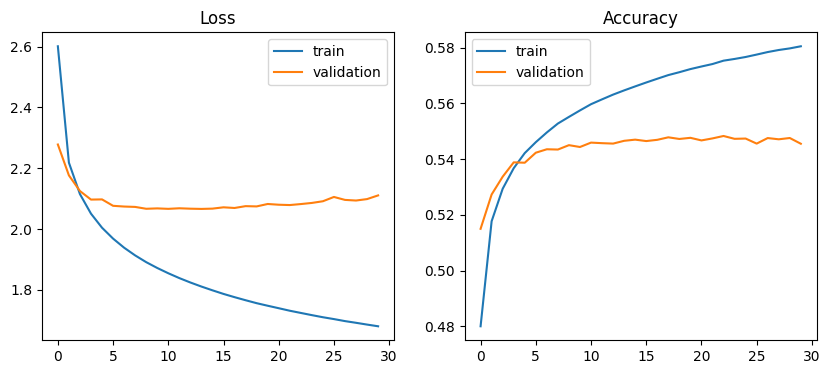

In [ ]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='train')
plt.plot(val_accuracies, label='validation')
plt.title('Accuracy')
plt.legend()

plt.show()

# Testing CNN + Default Transformer

The testing phase includes multiple components (Assume that we are starting off with a fresh python kernel):

1. Loading the best saved model and displaying model parameters
2. Evaluating the model using evaluation metrics

## Envrionment Setup and Dependencies

In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pycocotools.coco import COCO
import time
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.cider.cider import Cider
from transformers import AutoTokenizer
from torchinfo import summary

os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.backends.cuda.matmul.allow_tf32 = True

# Set random seeds for reproducibility
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='cuda')

## Dataset Configuration and Loading

In [2]:
class CocoDataset(Dataset):
    def __init__(self, root_dir, ann_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.coco = COCO(ann_file)
        self.ids = list(self.coco.anns.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        ann_id = self.ids[idx]
        caption = self.coco.anns[ann_id]['caption']
        img_id = self.coco.anns[ann_id]['image_id']
        path = self.coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.root_dir, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        return image, caption, img_id
    
# Load validation data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Set paths
BASE_DIR = 'data'
IMG_DIR = os.path.join(BASE_DIR, 'images')
ANN_DIR = os.path.join(BASE_DIR, 'annotations/trainval2017')

# Create validation dataset and loader
val_dataset = CocoDataset(
    root_dir=os.path.join(IMG_DIR, 'val2017'),
    ann_file=os.path.join(ANN_DIR, 'captions_val2017.json'),
    transform=transform
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=1, # Batch size of 1 to generate captions one by one
    shuffle=True,
    num_workers=0
)


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


## Tokenization Configuration

In [3]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

c:\Users\Jordan\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Model Loading

To load the model there are multiple components that we will execute:

   - Load from saved checkpoints
   - Restore model state
   - Configure for evaluation

In [4]:
class EncoderCNN(nn.Module):
    def __init__(self, hidden_size=512):
        super(EncoderCNN, self).__init__()
        
        # Keep the same ResNet50 encoder as Model 5
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        
        # Reduce channels to hidden_size
        self.conv_reduce = nn.Conv2d(2048, hidden_size, kernel_size=1)
        
        # Freeze ResNet parameters
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = self.conv_reduce(features)
        batch_size, hidden_size, width, height = features.shape
        features = features.permute(0, 2, 3, 1)
        features = features.view(batch_size, -1, hidden_size)
        return features

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super(PositionalEncoding, self).__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=6, nhead=8, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
        # Word embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(embed_size)
        
        # Transformer decoder layers
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=hidden_size,
            nhead=nhead,
            dim_feedforward=hidden_size * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        
        # Output layer
        self.output_layer = nn.Linear(hidden_size, vocab_size)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, size):
        # Generate causal mask for transformer decoder
        mask = torch.triu(torch.ones(size, size), diagonal=1).bool()
        return mask

    def forward(self, encoder_out, captions):
        # Embed captions
        embeddings = self.embed(captions)
        embeddings = self.pos_encoder(embeddings)
        embeddings = self.dropout(embeddings)
        
        # Create causal mask
        tgt_mask = self.generate_mask(captions.size(1)).to(captions.device)
        
        # Transformer decoder
        decoder_output = self.transformer_decoder(
            tgt=embeddings,
            memory=encoder_out,
            tgt_mask=tgt_mask
        )
        
        # Project to vocabulary size
        outputs = self.output_layer(decoder_output)
        return outputs

    def sample(self, features, tokenizer, max_len=20):
        self.eval()
        batch_size = features.size(0)
        device = features.device
        
        # Start with CLS token
        input_ids = torch.tensor([tokenizer.cls_token_id]).repeat(batch_size, 1).to(device)
        
        for _ in range(max_len - 1):
            # Embed current sequence
            embeddings = self.embed(input_ids)
            embeddings = self.pos_encoder(embeddings)
            
            # Create causal mask
            tgt_mask = self.generate_mask(input_ids.size(1)).to(device)
            
            # Get next token probabilities
            decoder_output = self.transformer_decoder(
                tgt=embeddings,
                memory=features,
                tgt_mask=tgt_mask
            )
            outputs = self.output_layer(decoder_output)
            
            # Select next token
            next_token = outputs[:, -1].argmax(dim=-1)
            
            # Append to sequence
            input_ids = torch.cat([input_ids, next_token.unsqueeze(1)], dim=1)
            
            # Break if SEP token is generated
            if next_token.item() == tokenizer.sep_token_id:
                break
        
        return input_ids

class TransformerCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=6, nhead=8):
        super(TransformerCaptioningModel, self).__init__()
        self.encoder = EncoderCNN(hidden_size)
        self.decoder = TransformerDecoder(
            embed_size=embed_size,
            hidden_size=hidden_size,
            vocab_size=vocab_size,
            num_layers=num_layers,
            nhead=nhead
        )

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def generate_caption(self, image, tokenizer, max_len=20):
        self.eval()
        with torch.no_grad():
            features = self.encoder(image.unsqueeze(0)) # Unsqueeze to add batch dimension
            caption_ids = self.decoder.sample(features, tokenizer, max_len)
            sampled_ids = caption_ids[0].cpu().numpy()
        
        caption = tokenizer.decode(sampled_ids, skip_special_tokens=True)
        return caption

In [5]:
MODEL_NAME = 'cnn+default transformer_best_model.pt'
CHECKPOINT_PATH = 'data/'
MODEL_PATH = os.path.join(CHECKPOINT_PATH, MODEL_NAME)

# Model hyperparameters
EMBED_SIZE = 512
HIDDEN_SIZE = 512
VOCAB_SIZE = tokenizer.vocab_size
NUM_LAYERS = 6
NHEAD = 8
learning_rate = 1e-4

# Create model instance
model = TransformerCaptioningModel(
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    nhead=NHEAD
).to(device)

checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

C:\Users\Jordan\AppData\Local\Temp\ipykernel_11296\913035859.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=device)


TransformerCaptioningModel(
  (encoder): EncoderCNN(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inp

## Model Visualization and Statistical Analysis

Detailed analysis of model performance:

1. **Visualization**:
   - Training curves
   - Accuracy progression
   - Loss trends

2. **Statistical Analysis**:
   - Model parameter count
   - Layer-wise analysis using torchinfo

Model was trained for 14 epochs
Final training loss: 1.8110
Final training accuracy: 0.5646
Final validation loss: 2.0664
Final validation accuracy: 0.5465
Training Loss history: [2.6013278776562916, 2.218598589434062, 2.1151051239860856, 2.0507720302157266, 2.0045043403072356, 1.9687241334084378, 1.9388139862409053, 1.9134437281025796, 1.891281491907048, 1.8721211450480142, 1.8547731469322526, 1.838846827703344, 1.8243652289640728, 1.8110284641951537]
Training Accuracy history: [0.4800087653883423, 0.5176909105551911, 0.5293323973958212, 0.5367194181400652, 0.5421412195959725, 0.5460489806515842, 0.5495437285759681, 0.5527366749035139, 0.5551163227632617, 0.5574416660034227, 0.5596765943934291, 0.5614175262904736, 0.563115799300969, 0.5646251137851543]
Validation Loss history: [2.2782602386401436, 2.176727201322765, 2.125218950726492, 2.0970839226947113, 2.097687188011911, 2.076598994567266, 2.0741994277290674, 2.0729642254312326, 2.0668573891720197, 2.0681151762947705, 2.066622356319

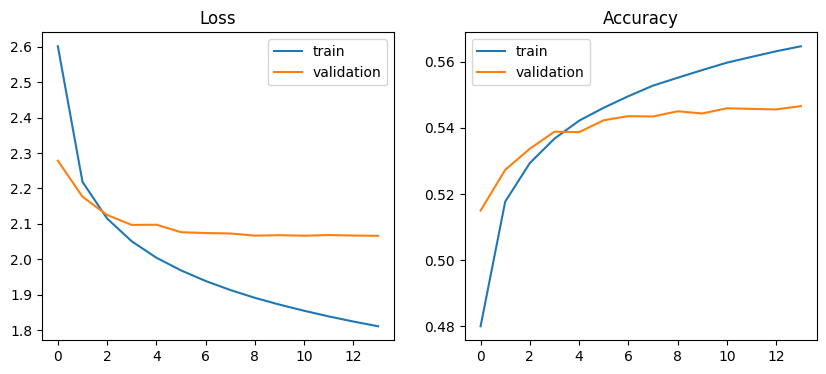

In [6]:
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
train_accuracy = checkpoint['train_accuracy']
val_loss = checkpoint['val_loss']
val_accuracy = checkpoint['val_accuracy']
print(f"Model was trained for {epoch + 1} epochs")
print(f"Final training loss: {train_loss:.4f}")
print(f"Final training accuracy: {train_accuracy:.4f}")
print(f"Final validation loss: {val_loss:.4f}")
print(f"Final validation accuracy: {val_accuracy:.4f}")

train_losses_history = checkpoint['train_losses']  # List of all training losses
train_accuracies_history = checkpoint['train_accuracies'] # List of training accuracies
val_losses_history = checkpoint['val_losses']      # List of all validation losses
val_accuracies_history = checkpoint['val_accuracies']  # List of validation accuracies
print(f"Training Loss history: {train_losses_history}")
print(f"Training Accuracy history: {train_accuracies_history}")
print(f"Validation Loss history: {val_losses_history}")
print(f"Validation Accuracy history: {val_accuracies_history}")

# Plot train and val loss and accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_history, label='train')
plt.plot(val_losses_history, label='validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_history, label='train')
plt.plot(val_accuracies_history, label='validation')
plt.title('Accuracy')
plt.legend()

plt.show()

In [7]:
# Concise summary
summary(model, 
        input_data=[
            torch.zeros(1, 3, 224, 224).to(device),
            torch.zeros(1, 50, dtype=torch.long).to(device)
        ],
        depth=2,  # Reduce depth to show less nested layers
        verbose=0,  # Reduce verbosity
        col_names=["output_size", "num_params"],  # Show only essential columns
        row_settings=["var_names"])

c:\Users\Jordan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\activation.py:1230: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                                           Output Shape              Param #
TransformerCaptioningModel (TransformerCaptioningModel)           [1, 50, 30522]            --
├─EncoderCNN (encoder)                                            [1, 49, 512]              --
│    └─Sequential (resnet)                                        [1, 2048, 7, 7]           (23,508,032)
│    └─Conv2d (conv_reduce)                                       [1, 512, 7, 7]            1,049,088
├─TransformerDecoder (decoder)                                    [1, 50, 30522]            --
│    └─Embedding (embed)                                          [1, 50, 512]              15,627,264
│    └─PositionalEncoding (pos_encoder)                           [1, 50, 512]              --
│    └─Dropout (dropout)                                          [1, 50, 512]              --
│    └─TransformerDecoder (transformer_decoder)                   [1, 50, 512]              25,224,192
│    └─Linea

In [8]:
# Create sample inputs for summary
batch_size = 1
channels = 3
image_height = 224
image_width = 224
seq_length = 50  # typical sequence length for captions

# Generate sample inputs
sample_image = torch.zeros(batch_size, channels, image_height, image_width)
sample_captions = torch.zeros(batch_size, seq_length, dtype=torch.long)

# Model Summary
summary(model, 
        input_data=[sample_image.to(device), sample_captions.to(device)],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        depth=4)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
TransformerCaptioningModel (TransformerCaptioningModel)           [1, 3, 224, 224]     [1, 50, 30522]       --                   Partial
├─EncoderCNN (encoder)                                            [1, 3, 224, 224]     [1, 49, 512]         --                   Partial
│    └─Sequential (resnet)                                        [1, 3, 224, 224]     [1, 2048, 7, 7]      --                   False
│    │    └─Conv2d (0)                                            [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
│    │    └─BatchNorm2d (1)                                       [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
│    │    └─ReLU (2)                                              [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
│    │    └─MaxPool2d (3)                         

## Evaluating Model on BLEU and CIDEr

The model's performance is evaluated using BLEU and CIDEr metrics in image captioning. The evaluation process involves:

1. **Data Collection**:
   - Keep track of unique image IDs to avoid duplicate processing
   - For each unique image:
     * Generate a model caption
     * Get all human reference captions from COCO dataset

2. **Score Calculation**:
   - For each unique image:
     * Compare model's caption with all human reference captions
     * Calculate BLEU-1 to BLEU-4, and CIDEr scores
   - Average all scores across the validation dataset

3. **Saving Results**:
   - Save all scores to a JSON file for later analysis
   - Record separate scores for each evaluation metric

In [ ]:
def evaluate_metrics(model, data_loader, max_samples=None):
    """Evaluate model using BLEU, METEOR, and CIDEr metrics
    
    If you face a Meteor Score ValueError implement the fix to 
    your pycocoevalcap/meteor/meteor.py file in the _stat method
    https://github.com/tylin/coco-caption/pull/35/commits/7352d54db5a4565ac561fa918766562e6acf93c3
    """
    model.eval()
    
    scorers = [
        (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
        (Meteor(), "METEOR"),
        (Cider(), "CIDEr")
    ]
    
    refs = {}
    hypos = {}
    processed_images = set()
    
    print("Generating predictions...")
    with torch.no_grad():
        for images, captions, img_ids in tqdm.tqdm(data_loader):
            current_img_id = img_ids[0].item()
            
            if current_img_id in processed_images:
                continue
            
            if max_samples and len(processed_images) >= max_samples:
                break
                
            processed_images.add(current_img_id)
            
            images = images.to(device)
            generated_caption = model.generate_caption(
                images[0],
                tokenizer
            )
            
            ann_ids = data_loader.dataset.coco.getAnnIds(imgIds=current_img_id)
            anns = data_loader.dataset.coco.loadAnns(ann_ids)
            reference_captions = [ann['caption'] for ann in anns]
            
            img_id_str = str(current_img_id)
            refs[img_id_str] = reference_captions
            hypos[img_id_str] = [generated_caption]
    
    print(f"\nComputing scores for {len(processed_images)} unique images...")
    scores = {}
    
    for scorer, method in scorers:
        print(f'Computing {method} score...')
        score, _ = scorer.compute_score(refs, hypos)
        if isinstance(method, list):
            for sc, m in zip(score, method):
                scores[m] = sc
        else:
            scores[method] = score
                
    return scores

# Evaluate model
print("Starting evaluation...")
val_scores = evaluate_metrics(model, val_loader)

# Print and save results
print("\nEvaluation Scores:")
print("=" * 50)
for metric, score in val_scores.items():
    print(f"{metric:<10}: {score:.4f}")
print("=" * 50)

Starting evaluation...
Generating predictions...


100%|██████████| 25014/25014 [11:53<00:00, 35.04it/s] 



Computing scores for 5000 unique images...
Computing ['Bleu_1', 'Bleu_2', 'Bleu_3', 'Bleu_4'] score...
{'testlen': 49373, 'reflen': 48594, 'guess': [49373, 44373, 39373, 34373], 'correct': [31229, 14580, 6230, 2769]}
ratio: 1.016030785693686
Computing METEOR score...
Computing CIDEr score...

Evaluation Scores:
Bleu_1    : 0.6325
Bleu_2    : 0.4559
Bleu_3    : 0.3204
Bleu_4    : 0.2269
METEOR    : 0.2523
CIDEr     : 0.6696


In [ ]:
# Save scores
with open(os.path.join(CHECKPOINT_PATH, f'{MODEL_NAME}_evaluation_scores.json'), 'w') as f:
    json.dump(val_scores, f, indent=4)
print(f"\nScores saved to {MODEL_NAME}_evaluation_scores.json")


Scores saved to best_transformer_model.pt_evaluation_scores.json


## Image Visualization and Caption Analysis

Comprehensive visualization utilities for model evaluation:

1. **Image Visualization**:
   - Denormalization for proper image display
   - Tensor to numpy conversion
   - Display formatting

2. **Caption Analysis**:
   - Side-by-side comparison of actual vs predicted captions
   - Multiple reference captions display
   - Metric scores for individual predictions


Generating sample visualizations...
5
{'testlen': 8, 'reflen': 8, 'guess': [8, 7, 6, 5], 'correct': [7, 3, 1, 0]}
ratio: 0.9999999998750002


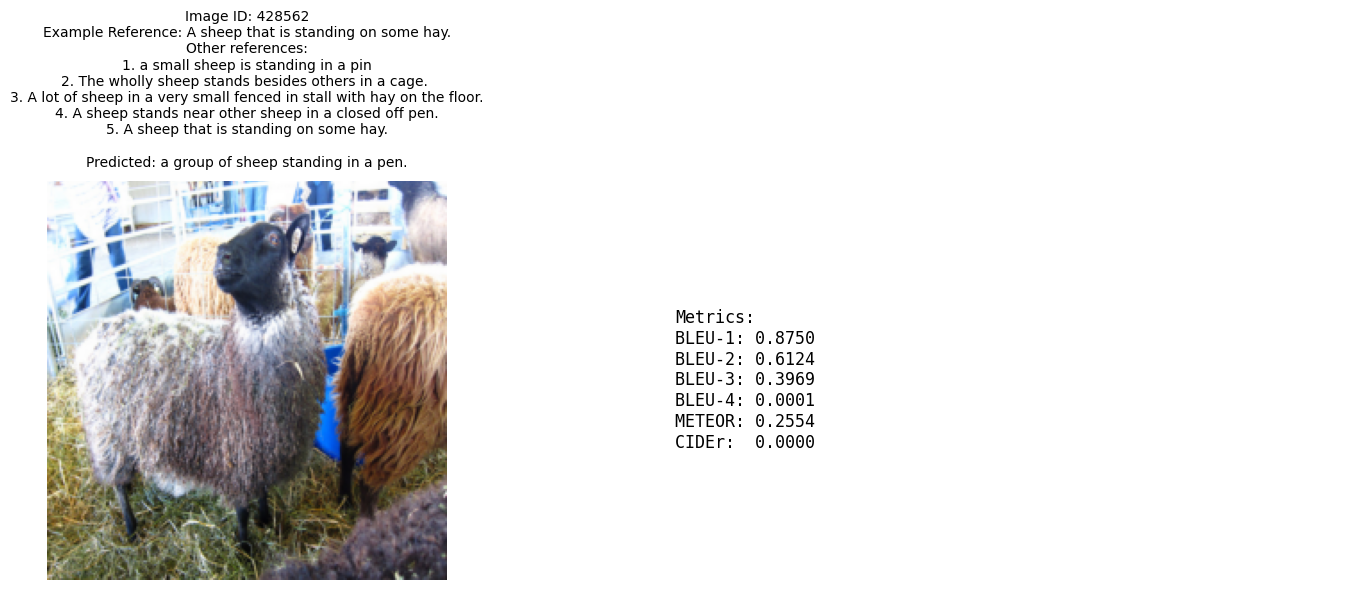

5
{'testlen': 10, 'reflen': 10, 'guess': [10, 9, 8, 7], 'correct': [9, 5, 3, 2]}
ratio: 0.9999999999000002


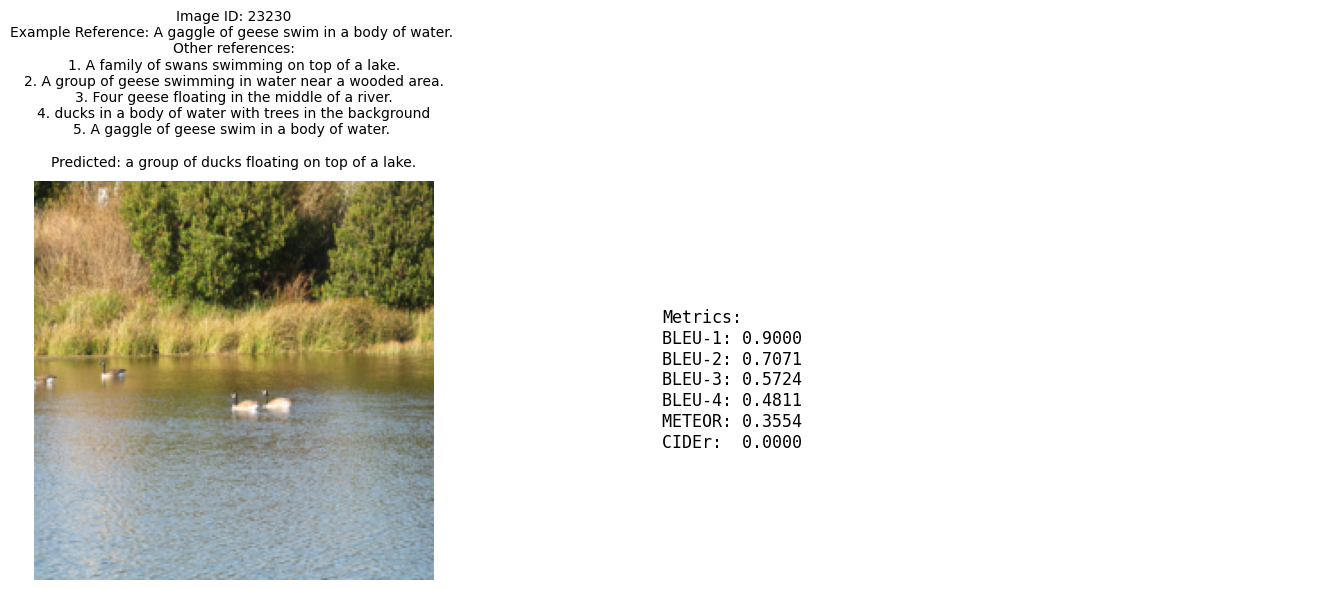

5
{'testlen': 12, 'reflen': 12, 'guess': [12, 11, 10, 9], 'correct': [9, 4, 3, 2]}
ratio: 0.9999999999166668


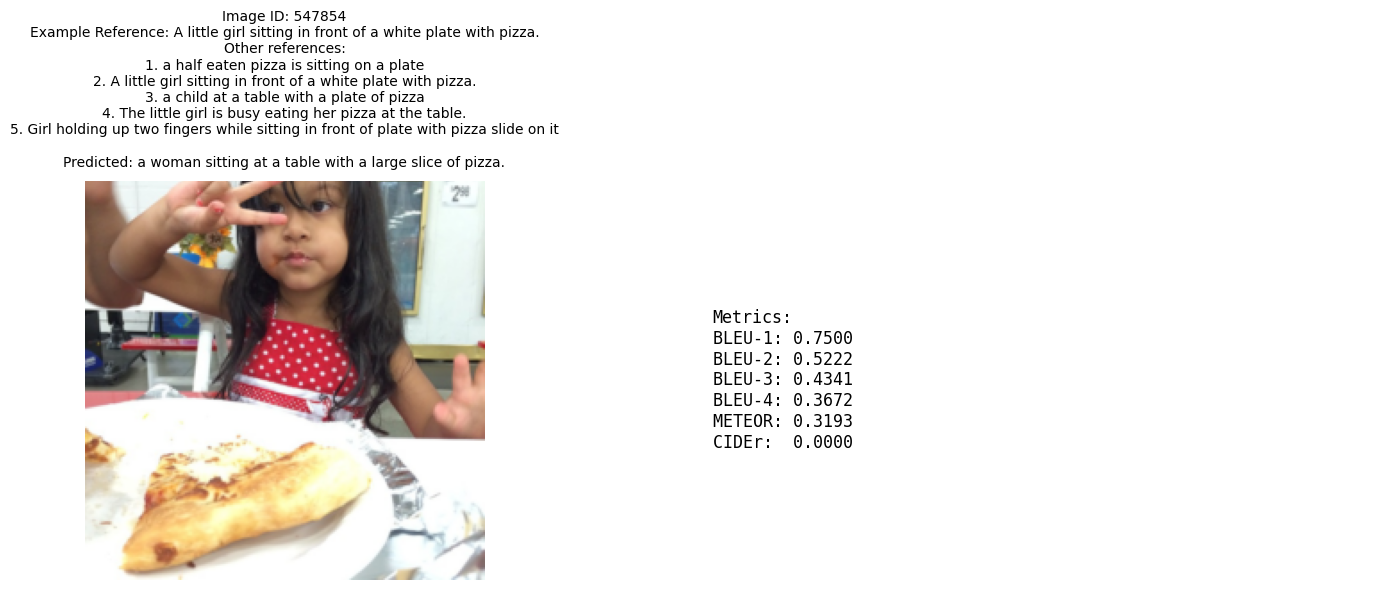

In [ ]:
def denormalize_image(image):
    """Denormalize image from [-1, 1] range to [0, 1] range"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(image.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(image.device)
    
    img = image * std + mean
    img = torch.clamp(img, 0, 1)
    return img

def calculate_single_caption_metrics(predicted_caption, reference_captions):
    """Calculate metrics for a single caption"""
    scorers = [
        (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
        (Meteor(), "METEOR"),
        (Cider(), "CIDEr")
    ]
    
    refs = {'0': reference_captions}
    hypos = {'0': [predicted_caption]}
    
    scores = {}
    for scorer, method in scorers:
        score, _ = scorer.compute_score(refs, hypos)
        if isinstance(method, list):
            for sc, m in zip(score, method):
                scores[m] = sc
        else:
            scores[method] = score
            
    return scores

def visualize_sample(image, actual_caption, all_captions, predicted_caption, img_id=None):
    """Visualize a single sample with metrics"""
    plt.figure(figsize=(15, 6))
    
    # Image and captions subplot
    plt.subplot(1, 2, 1)
    img_denorm = denormalize_image(image)
    plt.imshow(img_denorm.cpu().permute(1, 2, 0).numpy())
    
    # Calculate metrics
    scores = calculate_single_caption_metrics(predicted_caption, all_captions)
    
    # Create title with image ID and captions
    title = f'Image ID: {img_id.item()}\n' if img_id is not None else ''
    title += f'Example Reference: {actual_caption}\n'
    title += f'Other references:\n'
    for i, cap in enumerate(all_captions, 1):
        title += f'{i}. {cap}\n'
    title += f'\nPredicted: {predicted_caption}'
    
    plt.title(title, fontsize=10, pad=10)
    plt.axis('off')
    
    # Metrics subplot
    metrics_text = (
        f"Metrics:\n"
        f"BLEU-1: {scores['Bleu_1']:.4f}\n"
        f"BLEU-2: {scores['Bleu_2']:.4f}\n"
        f"BLEU-3: {scores['Bleu_3']:.4f}\n"
        f"BLEU-4: {scores['Bleu_4']:.4f}\n"
        f"METEOR: {scores['METEOR']:.4f}\n"
        f"CIDEr:  {scores['CIDEr']:.4f}"
    )
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.5, metrics_text, 
             fontsize=12, family='monospace',
             verticalalignment='center')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_multiple_samples(model, dataloader, num_samples=3):
    """Visualize multiple samples with their actual and predicted captions"""
    model.eval()
    
    for _ in range(num_samples):
        # Get a sample
        image, caption, img_id = next(iter(dataloader))
        image = image[0].to(device)
        
        # Get reference captions using COCO API
        reference_captions = []
        ann_ids = dataloader.dataset.coco.getAnnIds(imgIds=img_id.item())
        anns = dataloader.dataset.coco.loadAnns(ann_ids)
        print(len(anns))
        for ann in anns:
            reference_captions.append(ann['caption'])
        
        # Generate predicted caption
        predicted_caption = model.generate_caption(
            image,
            tokenizer
        )
        
        # Visualize the sample
        visualize_sample(image, caption[0], reference_captions, predicted_caption, img_id)

# Visualize some samples
print("\nGenerating sample visualizations...")
visualize_multiple_samples(model, val_loader, num_samples=3)

{'testlen': 9, 'reflen': 9, 'guess': [9, 8, 7, 6], 'correct': [6, 1, 0, 0]}
ratio: 0.9999999998888891


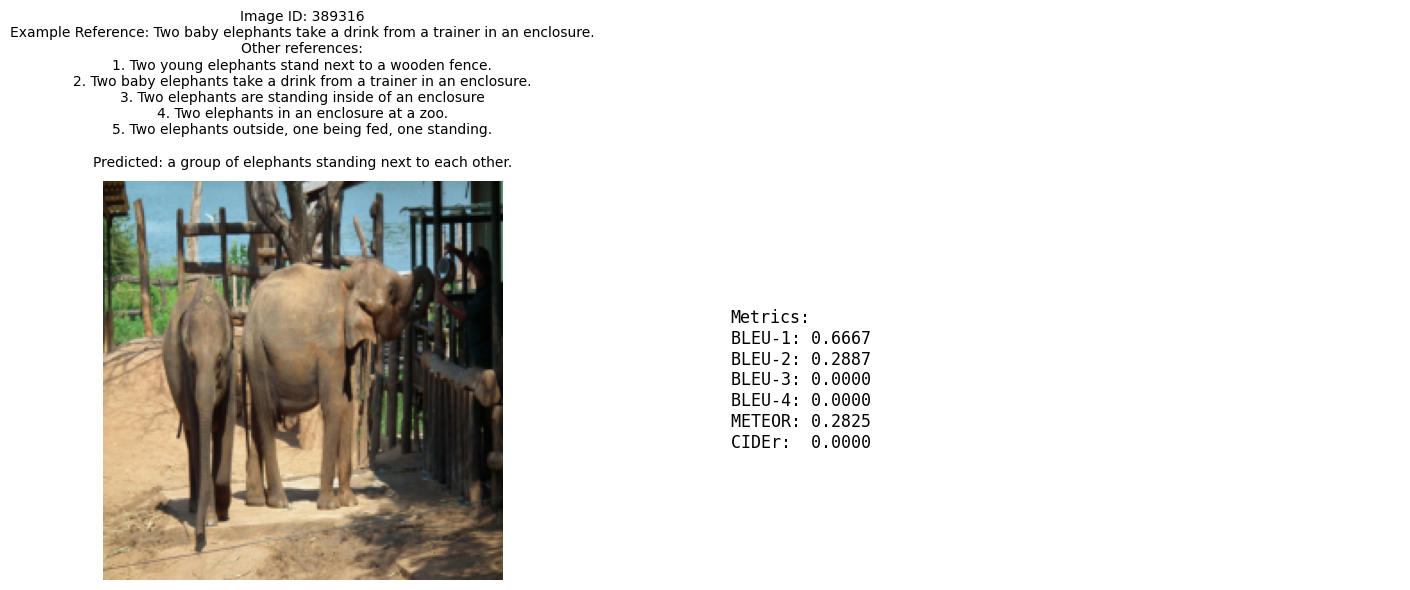

Image ID: 389316


In [ ]:
# For single image
image, caption, img_id = next(iter(val_loader))
image = image[0].to(device)

# Get actual caption (which is already a string with the BERT tokenizer version)
actual_caption = caption[0]

# Get other captions directly using COCO API
all_captions = []
ann_ids = val_dataset.coco.getAnnIds(imgIds=img_id.item())
anns = val_dataset.coco.loadAnns(ann_ids)
for ann in anns:
    all_captions.append(ann['caption'])

# Generate predicted caption using the BERT tokenizer version
predicted_caption = model.generate_caption(
    image,
    tokenizer
)

# Display the results with image ID and other actual captions
visualize_sample(image, actual_caption, all_captions, predicted_caption, img_id)
print(f"Image ID: {img_id.item()}")